In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
# %matplotlib notebook

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH
%aimport models.AEFIT5
%aimport models.Compose
%aimport models.GAN3

import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass
    def on_test_begin(self, a): pass
    def on_test_end(self, a): pass
    def on_test_batch_begin(self, a, b): pass
    def on_test_batch_end(self, a, b): pass

    
class PlotRelevanceCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(13, 3)
        w = self.model.layers[0].weights
        ax1.bar(range(0,4), w[0][0:4])
        labels = ['Ip','NS','Vt','F']
        plt.sca(ax1)
        plt.xticks(range(0,4), labels, fontsize=10)
        ax2.bar(range(7,17), w[0][4:14])
        plt.sca(ax2)
        plt.xticks(range(7,17), fontsize=10)        
        ax3.bar(range(7,17), w[0][14:24])
        plt.sca(ax3)
        plt.xticks(range(7,17), fontsize=10)       


# ipysh.Bootstrap_support.debug()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


Using TensorFlow backend.


# TEST QSH


In [2]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15_clean.npy'
try: qsh.load(file)
except: raise FileNotFoundError
    
qsh.shuffle()
qsh.dim = None
qsh.set_null(np.nan)
qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F'])  ## use this for Br_rm
# qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F','absBr_rm','argBr_rm']) 

# qsh.unbias_mean(0.5, 'te')
# qsh.set_normal_positive(['te'])
# qsh.clip_values(0.1,0.6)
# qsh.set_normal_positive(['te'])

print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  47567


In [3]:
# Bt_min, Bt_max = np.nanmin(qsh['Bt_rm']), np.nanmax(qsh['Bt_rm'])
Br_min, Br_max = np.nanmin(qsh['Br_rm']), np.nanmax(qsh['Br_rm'])

def _map(xy,p,Br):
    # Bt = (Bt-Bt_min)/(Bt_max-Bt_min)
    Br = (Br-Br_min)/(Br_max-Br_min)
    pBr = tf.concat([p,Br], axis=0)
    # return (xy,pBtBr),(xy,pBtBr)
    return pBr,xy

# ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','absBr_rm~argBr_rm']).map(lambda x,y,br: _map(x,y,br) )
ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','Br_rm']).map(lambda x,y,br: _map(x,y,br) )
[x for x in ds.shuffle(100).batch(1).take(1)][0]

W0903 15:20:01.988927 139757364451136 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:504: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


(<tf.Tensor: id=60, shape=(1, 24), dtype=float32, numpy=
 array([[0.39212835, 0.67282873, 0.43180248, 0.74514633, 0.43799904,
         0.28572404, 0.29252267, 0.27635652, 0.27318123, 0.28531858,
         0.27232686, 0.2835407 , 0.2821541 , 0.29672858, 0.5322701 ,
         0.27705318, 0.273612  , 0.2731774 , 0.2816222 , 0.27720192,
         0.29751393, 0.2919321 , 0.27881426, 0.2746698 ]], dtype=float32)>,
 <tf.Tensor: id=61, shape=(1, 30), dtype=float32, numpy=
 array([[0.07706854, 0.10227603, 0.14960876, 0.2092722 , 0.27422595,
         0.34855986, 0.42947042, 0.51404023, 0.59861016, 0.6795207 ,
         0.7538546 , 0.8198561 , 0.87915146, 0.9260032 , 0.9629103 ,
         0.13410318, 0.14692971, 0.1604566 , 0.16866362, 0.16506758,
         0.1799021 , 0.19420865, 0.23947348, 0.26525807, 0.26261964,
         0.24084567, 0.1852982 , 0.19107984, 0.18028371, 0.15376894]],
       dtype=float32)>)

In [4]:
vae = models.AEFIT5.AEFIT5(latent_dim=6, feature_dim=30, dprate=0.1, beta=0., scale=2, geometry=[20,20,10,10])
vae.build(input_shape=vae.inference_net.input_shape)
vae.compile( vae.optimizer, tf.losses.mse )


AEFIT5 a ready:


In [5]:
dds = ds.map(lambda p,xy: (xy,xy))
vae_history = vae.fit( dds.skip(5000).batch(100, drop_remainder=True), validation_data=dds.take(5000).batch(100), epochs=50)

Epoch 1/500
425/425 [==============================] - 32s 76ms/step - loss: 0.0057 - val_loss: 0.0000e+00
Epoch 2/500
425/425 [==============================] - 30s 71ms/step - loss: 8.5975e-04 - val_loss: 4.1832e-04
Epoch 3/500
425/425 [==============================] - 30s 71ms/step - loss: 6.9915e-04 - val_loss: 4.2573e-04
Epoch 4/500
425/425 [==============================] - 30s 70ms/step - loss: 6.2929e-04 - val_loss: 4.4364e-04
Epoch 5/500
425/425 [==============================] - 32s 74ms/step - loss: 5.8920e-04 - val_loss: 4.0933e-04
Epoch 6/500
425/425 [==============================] - 31s 73ms/step - loss: 5.5327e-04 - val_loss: 3.9488e-04
Epoch 7/500
425/425 [==============================] - 31s 73ms/step - loss: 5.4020e-04 - val_loss: 3.9075e-04
Epoch 8/500
425/425 [==============================] - 31s 73ms/step - loss: 4.6183e-04 - val_loss: 2.4003e-04
Epoch 9/500
425/425 [==============================] - 30s 70ms/step - loss: 3.8156e-04 - val_loss: 2.4369e-04
Epoch

Epoch 147/500
425/425 [==============================] - 28s 67ms/step - loss: 2.0585e-04 - val_loss: 1.3530e-04
Epoch 148/500
425/425 [==============================] - 28s 65ms/step - loss: 2.0520e-04 - val_loss: 1.0234e-04
Epoch 149/500
425/425 [==============================] - 28s 66ms/step - loss: 2.1757e-04 - val_loss: 1.3815e-04
Epoch 150/500
425/425 [==============================] - 28s 66ms/step - loss: 2.1660e-04 - val_loss: 1.1619e-04
Epoch 151/500
425/425 [==============================] - 28s 66ms/step - loss: 2.1799e-04 - val_loss: 1.3208e-04
Epoch 152/500
425/425 [==============================] - 28s 66ms/step - loss: 2.1003e-04 - val_loss: 1.1740e-04
Epoch 153/500
425/425 [==============================] - 28s 66ms/step - loss: 2.0780e-04 - val_loss: 1.2470e-04
Epoch 154/500
425/425 [==============================] - 28s 66ms/step - loss: 2.0671e-04 - val_loss: 1.1759e-04
Epoch 155/500
425/425 [==============================] - 28s 66ms/step - loss: 1.9903e-04 - val_

425/425 [==============================] - 27s 64ms/step - loss: 2.2405e-04 - val_loss: 2.2486e-04
Epoch 292/500
425/425 [==============================] - 27s 65ms/step - loss: 2.1158e-04 - val_loss: 1.4663e-04
Epoch 293/500
425/425 [==============================] - 28s 65ms/step - loss: 2.0963e-04 - val_loss: 1.7787e-04
Epoch 294/500
425/425 [==============================] - 27s 65ms/step - loss: 2.1005e-04 - val_loss: 1.3794e-04
Epoch 295/500
425/425 [==============================] - 28s 65ms/step - loss: 2.0813e-04 - val_loss: 1.0170e-04
Epoch 296/500
425/425 [==============================] - 28s 66ms/step - loss: 2.0989e-04 - val_loss: 1.3273e-04
Epoch 297/500
425/425 [==============================] - 27s 64ms/step - loss: 2.0676e-04 - val_loss: 1.3610e-04
Epoch 298/500
425/425 [==============================] - 28s 65ms/step - loss: 2.0764e-04 - val_loss: 1.3801e-04
Epoch 299/500
425/425 [==============================] - 28s 65ms/step - loss: 2.2029e-04 - val_loss: 1.7479e-

425/425 [==============================] - 28s 65ms/step - loss: 2.0812e-04 - val_loss: 1.5700e-04
Epoch 436/500
425/425 [==============================] - 28s 65ms/step - loss: 2.4698e-04 - val_loss: 1.4606e-04
Epoch 437/500
425/425 [==============================] - 28s 65ms/step - loss: 2.3174e-04 - val_loss: 1.6708e-04
Epoch 438/500
425/425 [==============================] - 28s 65ms/step - loss: 2.2216e-04 - val_loss: 1.3771e-04
Epoch 439/500
425/425 [==============================] - 28s 65ms/step - loss: 2.1521e-04 - val_loss: 1.4375e-04
Epoch 440/500
425/425 [==============================] - 28s 65ms/step - loss: 2.0988e-04 - val_loss: 1.1493e-04
Epoch 441/500
425/425 [==============================] - 28s 65ms/step - loss: 2.0753e-04 - val_loss: 1.5442e-04
Epoch 442/500
425/425 [==============================] - 28s 65ms/step - loss: 2.1099e-04 - val_loss: 1.8413e-04
Epoch 443/500
425/425 [==============================] - 28s 65ms/step - loss: 2.1380e-04 - val_loss: 1.4507e-

In [1]:
vae_history

NameError: name 'vae_history' is not defined

In [6]:
vae1 = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=24, dprate=0.1, scale=1, geometry=[40,40,20,20])
vae1.generative_net.trainable = False
gen = vae1.inference_net

AEFIT5 a ready:


In [7]:
Dds = ds.map(lambda p,xy: (p, tf.reshape(vae.encode(tf.reshape(xy,[1,-1]),training=False)[0],[-1])) )
[x for x in Dds.batch(1).take(1)][0]

(<tf.Tensor: id=1172891, shape=(1, 24), dtype=float32, numpy=
 array([[0.6547206 , 0.57765174, 0.6813571 , 0.6478355 , 0.33941352,
         0.25898123, 0.27860597, 0.27167976, 0.28355896, 0.28322998,
         0.28290436, 0.2748986 , 0.27614188, 0.29172128, 0.5047813 ,
         0.30157152, 0.27829129, 0.27166277, 0.27917448, 0.27170232,
         0.28262237, 0.28347093, 0.2709516 , 0.28016126]], dtype=float32)>,
 <tf.Tensor: id=1172892, shape=(1, 6), dtype=float32, numpy=
 array([[ 3.6912358 ,  5.9066014 ,  2.4549916 , -9.423133  ,  6.129905  ,
         -0.11660042]], dtype=float32)>)

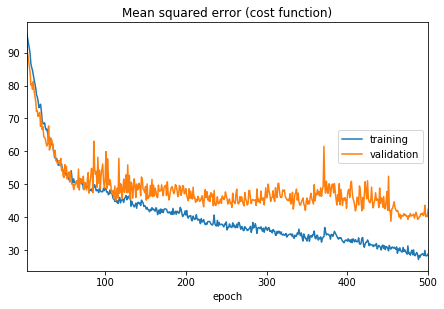

Mean squared error (cost function):
training   (min:   27.105, max:  112.895, cur:   28.778)
validation (min:   38.710, max:   94.514, cur:   42.392)
100/100 [==============================] - 29s 290ms/step - loss: 28.7783 - val_loss: 42.3923


In [8]:

# TRAIN MODEL
rel = gen.layers[0]
rel.rate = 0.
# l1_l2 = tf.keras.regularizers.l1_l2
# for l in gen.layers:
#     if issubclass(type(l), tf.keras.layers.Dense):
#         l.activity_regularizer = l1_l2(0.01)

gen.compile( tf.optimizers.Adam(1e-3), tf.losses.mse )
print(rel.weights)        
    
# qsh.shuffle()
history = gen.fit( Dds.skip(3000).batch(100).take(100), validation_data=Dds.take(3000).batch(100).take(100), epochs=500,
                  callbacks=[PlotLossesCallback()] )

In [9]:
gen.layers[1].weights

[<tf.Variable 'aefi_t5_1_iRlv/kernel:0' shape=(24,) dtype=float32, numpy=
 array([ 8.4993106e-01,  8.5889602e-01,  8.1633079e-01,  8.3623362e-01,
         9.9999988e-01,  1.6005158e-02,  3.7904197e-01,  9.5035982e-01,
         7.4787182e-01,  1.2510526e-01, -7.3831681e-05,  5.8512193e-01,
         8.8148899e-02,  8.1521861e-02,  9.9652398e-01,  1.0328330e-01,
         3.6777395e-01,  9.6399808e-01,  5.3154314e-01,  3.6495772e-01,
         6.0403311e-01,  6.6654943e-02,  2.8557131e-01,  2.9204690e-01],
       dtype=float32)>]

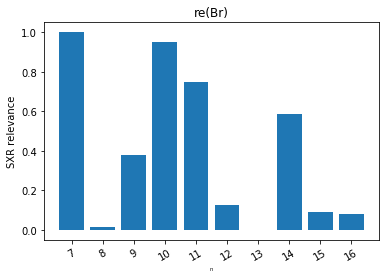

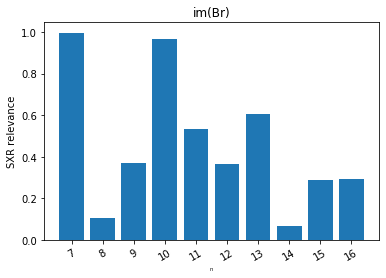

In [10]:
index = qsh[0].n
w = gen.layers[1].weights
%matplotlib inline

def plot_bar_x(index, w, title):
    # this is for plotting purpose
    plt.figure(title)
    plt.bar(index, w)
    plt.xlabel('n', fontsize=5)
    plt.ylabel('SXR relevance', fontsize=10)
    plt.xticks(index, fontsize=10, rotation=30)
    plt.title(title)
    plt.show()

re,im = w[0][4:14], w[0][14:24]
plot_bar_x(index, re, 're(Br)')
plot_bar_x(index, im, 'im(Br)')


In [11]:
# vae.save('step12_gan_PBr_reim')
# vae.load('step12_gan_PBr_reim')

In [12]:
pos = 0

0


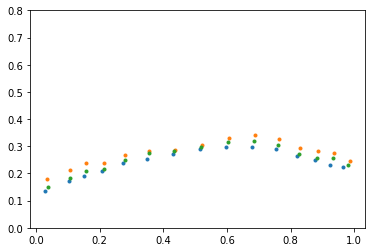

In [13]:
print(pos)
d_pos = [x for x in ds.skip(pos).batch(1).take(1)][0]

def plot(xy):
    plt.figure('plot')
    ax = plt.gca()
    ax.set_ylim(0.,0.8)
    xy = tf.reshape(xy, [-1])
    x,y = tf.split(xy, num_or_size_splits=2, axis=0)
    plt.plot(x,y,'.')

xy = d_pos[1]
XY_vae = vae(xy, training=False)
ls = gen(d_pos[0], training=False)
XY = vae.decode(ls, training=False)
# XY = tf.sigmoid(XY)
plot(xy)
plot(XY)
plot(XY_vae)
pos += 1